In [1]:
from dataset_helpers import *
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np 
import faiss

### Flicker-8k dataset

In [1]:
pwd

'/home/ntnhu/projects/VideoFall-VBS2022/searching'

In [1]:
from dataset_helpers import *
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
DATASET_PATH

'/home/ntnhu/DCU/projects/object_detection/dataset/Flicker-8k'

In [3]:
data = dataset(src_path=DATASET_PATH, feature_path=FEATURE_PATH)
data.get_file_name()
data.preprocess_dataset(entire_dataset=False)
# data.load_dataset()
print("Features: ", data.features)

 10%|█         | 1/10 [00:00<00:01,  5.70it/s]

Preprocess a subset of the dataset...


100%|██████████| 10/10 [00:01<00:00,  7.94it/s]

Features:  None


In [3]:
query = "two people"
best_images = data.search_query(query, num_matches=10)
print("Length of features: ", len(data.features))
print("Best images: ", best_images)

Length of features:  8091
Best images:  [(0.2883, 8018), (0.2834, 5003), (0.2815, 844), (0.2798, 299), (0.2747, 7635), (0.2734, 125), (0.2727, 1396), (0.2712, 6869), (0.2703, 2844), (0.2698, 4334)]


In [4]:
# def plot_figure(images, subplot_size=(5, 3), savefig=False):
#     fig = plt.figure(figsize=(15, 15))
#     max_len = min(len(images), subplot_size[0]*subplot_size[1])

#     for cnt, data in enumerate(images[:max_len]):
#     #     print(data)
#         y = fig.add_subplot(subplot_size[0], subplot_size[1], cnt+1)
# #         img = mpimg.imread(os.path.join(cluster_path, data))
# #         img = mpimg.imread(data)
#         img = Image.open(data)
#         y.imshow(img)
#         plt.title(data.split('/')[-1])
#         y.axes.get_xaxis().set_visible(False)
#         y.axes.get_yaxis().set_visible(False)

#     if savefig:
#         fig.savefig(os.path.join(path, f'{cluster_name}.png'))

In [4]:
len(best_images)

10

In [5]:
best_images

[(0.2883, 8018),
 (0.2834, 5003),
 (0.2815, 844),
 (0.2798, 299),
 (0.2747, 7635),
 (0.2734, 125),
 (0.2727, 1396),
 (0.2712, 6869),
 (0.2703, 2844),
 (0.2698, 4334)]

In [6]:
temp = [data.image_names[item[1]] for item in best_images]
temp

['/home/ntnhu/DCU/others/object_detection/dataset/Flicker-8k/Images/923550133_ac9d7a2932.jpg',
 '/home/ntnhu/DCU/others/object_detection/dataset/Flicker-8k/Images/3312096605_f458757418.jpg',
 '/home/ntnhu/DCU/others/object_detection/dataset/Flicker-8k/Images/2038662925_f4fa8c2534.jpg',
 '/home/ntnhu/DCU/others/object_detection/dataset/Flicker-8k/Images/1332208215_fa824f6659.jpg',
 '/home/ntnhu/DCU/others/object_detection/dataset/Flicker-8k/Images/527272653_8a5bd818e5.jpg',
 '/home/ntnhu/DCU/others/object_detection/dataset/Flicker-8k/Images/1131804997_177c3c0640.jpg',
 '/home/ntnhu/DCU/others/object_detection/dataset/Flicker-8k/Images/2273028514_d7b584f73d.jpg',
 '/home/ntnhu/DCU/others/object_detection/dataset/Flicker-8k/Images/3687062281_e62f70baf3.jpg',
 '/home/ntnhu/DCU/others/object_detection/dataset/Flicker-8k/Images/2752230113_b5dab6f0f1.jpg',
 '/home/ntnhu/DCU/others/object_detection/dataset/Flicker-8k/Images/3173157541_70b16b4318.jpg']

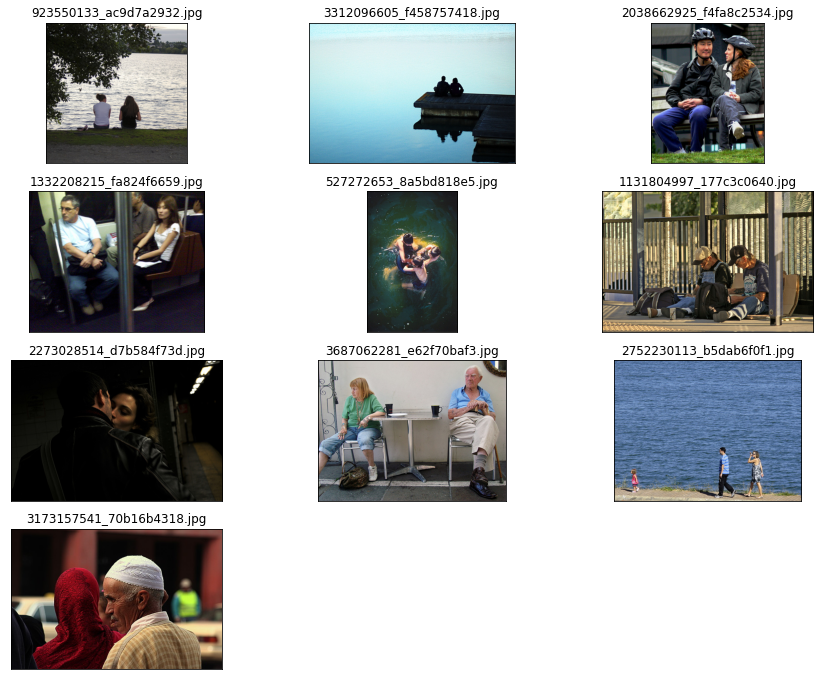

In [7]:
data.display_results(best_images)

### Using V3C1 sample dataset

In [2]:
DATASET_PATH

'/mnt/DEAKIN/VBS2022/keyframes'

In [3]:
# Whether you wanna generate new features
generate_features = True

print("Dataset name: ", DATASET_NAME)
clip = CLIPSearchEngine(src_path=DATASET_PATH, feature_path=FEATURE_PATH, generate_features=generate_features)

Dataset name:  V3C


In [4]:
# data = dataset(src_path=DATASET_PATH, feature_path=FEATURE_PATH, generate_features=generate_features)
# data.get_file_name()

In [4]:
clip.dataset.src_path

'/mnt/DEAKIN/VBS2022/keyframes'

In [5]:
clip.dataset.get_file_name()

Loading all image names ...


In [6]:
# clip.dataset.image_names[:10]

In [8]:
# joblib.dump(clip.dataset.image_names, f'../results/{DATASET_NAME}_image_names.joblib')

['../results/LSC_image_names.joblib']

In [7]:
temp = joblib.load(os.path.join(MASTER_PATH, 'results', f'{DATASET_NAME}_image_names.joblib'))

In [8]:
len(temp)

2508110

In [9]:
len(clip.dataset.image_names)

2508110

In [8]:
# clip.dataset.image_names[:100]

In [8]:
# clip.encode_dataset(entire_dataset=False)

#### Adjust the encoding function

In [6]:
import joblib

In [7]:
entire_dataset = False
if entire_dataset:
    print('Preprocess the whole dataset...')
    batches = math.ceil(len(self.image_names) / self.batch_size)
else:
    print('Preprocess a subset of the dataset...')
    batches = 10



Preprocess a subset of the dataset...


#### Test faiss

Implement faiss algorithm for vector similarity search. After computing features, we will use faiss instead of Cosine similarity (the goal is to check whether it is faster or not).

In [10]:
clip.load_features()
print("Features: ", len(clip.features))

Loading feature files ...


100%|██████████| 156757/156757 [01:45<00:00, 1489.51it/s]


Features:  2508110


In [11]:
query = "snow mountain"

In [12]:
text_encoded = clip.clip_model.encode_text_query(query)
    
# Retrieve the description vector and the image vectors
text_features = text_encoded.cpu().numpy().astype('float32')


In [33]:
type(text_features), text_features.shape

(numpy.ndarray, (1, 512))

In [35]:
# dimension = features.shape[1]
# nlist = 100

In [70]:
quantiser = faiss.IndexFlatL2(dimension)  
index = faiss.IndexIVFFlat(quantiser, dimension, nlist, faiss.METRIC_L2)

In [71]:
print(index.is_trained)   # False
index.train(features)  # train on the database vectors
print(index.ntotal)   # 0
index.add(features)   # add the vectors and update the index
print(index.is_trained)  # True
print(index.ntotal)   # 200

False
0
True
467488


In [72]:
nprobe = 2  # find 2 most similar clusters
# n_query = 10  
k = 100  # return 3 nearest neighbours
np.random.seed(0)   
# query_vectors = np.random.random((n_query, dimension)).astype('float32')
distances, indices = index.search(text_features, k)

In [73]:
indices

array([[181879, 181922, 283271, 342935, 456196, 138014,  76985, 456237,
        456215, 456227, 260736, 138007, 455051, 266858, 181904, 181897,
        109372, 456083,  95765, 290913, 283334, 234701, 456208, 456044,
        456248, 262990, 128358, 162248, 345315, 203366, 460419, 457121,
        367236, 266854, 283141, 193924, 455946, 343026, 181881, 390192,
        455217, 128196, 456141, 328948, 322292, 240601,  64947, 283139,
        181903, 456148, 254827, 456149, 359846, 174215, 456199, 358590,
        337006, 342934,  58669, 254937, 151011, 174354, 436454,  73683,
        442620, 430710, 425296, 456144,  65468,  80575, 455183, 254828,
        329302, 273732, 248138,  12601, 455951, 456242, 140753, 260671,
        273785, 171841, 155733, 456295, 273745, 456146, 273746, 456289,
        181896, 174218, 456167, 363707,  80267, 390202, 416248, 440283,
        374945, 193628, 328959, 112403]])

In [74]:
temp = [clip.dataset.image_names[x] for x in indices[0]]

In [18]:
# TEST COSINE SIMILARITIES
similarities = list((text_features @ clip.features.T).squeeze(0))

# Sort the images by their similarity scores
indices = sorted(zip(similarities, range(clip.features.shape[0])), key=lambda x: x[0], reverse=True)
# result = indices

In [22]:
distance, result = zip(*indices)

In [2]:
temp_list = os.listdir('/mnt/DEAKIN/VBS2022/resized_keyframes')

In [3]:
len(temp_list)

2097152

#### Compute features

In [7]:
# data.encode_dataset(entire_dataset=True)
# data.load_dataset()
# print("Features: ", clip.features==None)

In [6]:
clip.load_features()
print("Features: ", len(clip.features))

Loading feature files ...


100%|██████████| 156757/156757 [01:41<00:00, 1550.30it/s]


Features:  2508110


In [13]:
# query = 'Taking a photograph of an A380 airplane in Germany'
# img_name = '/mnt/data/lsc2020/2015-03-11/b00000022_21i6bq_20150311_065204e.jpg'
# query = convert_to_concepts(img_name, dataset_name=DATASET_NAME)['filename']
query = 'two man hugging'

In [14]:
x = clip.encode_input_query(query)
x.shape

(1, 512)

In [17]:
# best_images

Time:  3.4604718685150146
Length of features:  2508110
Can't find best matched images.


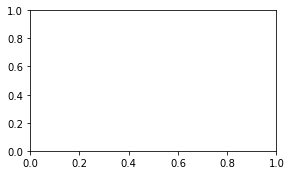

In [15]:
import time
begin = time.time()
best_images = clip.search_query(query, num_matches=20, ss_type='other')
# best_images = clip.search_query(query, num_matches=100, nlist=10, ss_type='faiss')
end = time.time()
print("Time: ", end - begin)
print("Length of features: ", len(clip.features))
clip.display_results(best_images[:15])
# print("Best images: ", best_images)

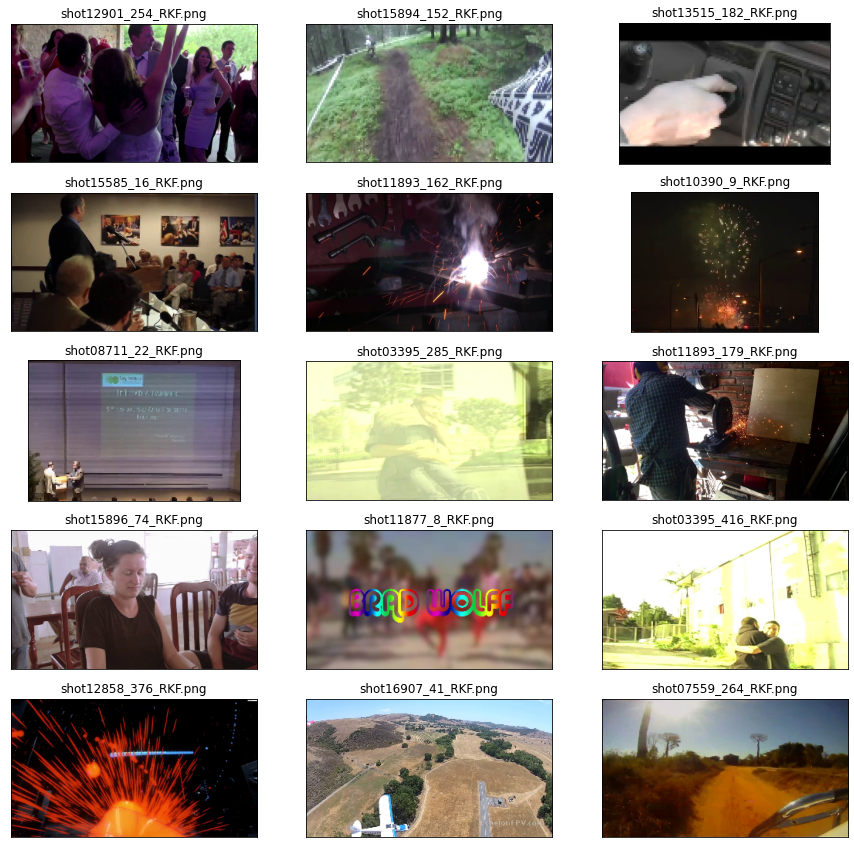

In [17]:
image_ids = [osp.join(clip.dataset.src_path, item['path']) for item in best_images]
plot_figures(image_ids)

In [11]:
best_images

[{'path': '/mnt/DEAKIN/VBS2022/keyframes/12901/shot12901_254_RKF.png',
  'filename': 'shot12901_254_RKF.png',
  'dataset': None,
  'video': '12901',
  'shot': '254'},
 {'path': '/mnt/DEAKIN/VBS2022/keyframes/15894/shot15894_152_RKF.png',
  'filename': 'shot15894_152_RKF.png',
  'dataset': None,
  'video': '15894',
  'shot': '152'},
 {'path': '/mnt/DEAKIN/VBS2022/keyframes/13515/shot13515_182_RKF.png',
  'filename': 'shot13515_182_RKF.png',
  'dataset': None,
  'video': '13515',
  'shot': '182'},
 {'path': '/mnt/DEAKIN/VBS2022/keyframes/15585/shot15585_16_RKF.png',
  'filename': 'shot15585_16_RKF.png',
  'dataset': None,
  'video': '15585',
  'shot': '16'},
 {'path': '/mnt/DEAKIN/VBS2022/keyframes/11893/shot11893_162_RKF.png',
  'filename': 'shot11893_162_RKF.png',
  'dataset': None,
  'video': '11893',
  'shot': '162'},
 {'path': '/mnt/DEAKIN/VBS2022/keyframes/10390/shot10390_9_RKF.png',
  'filename': 'shot10390_9_RKF.png',
  'dataset': None,
  'video': '10390',
  'shot': '9'},
 {'path

In [1]:
# best_images

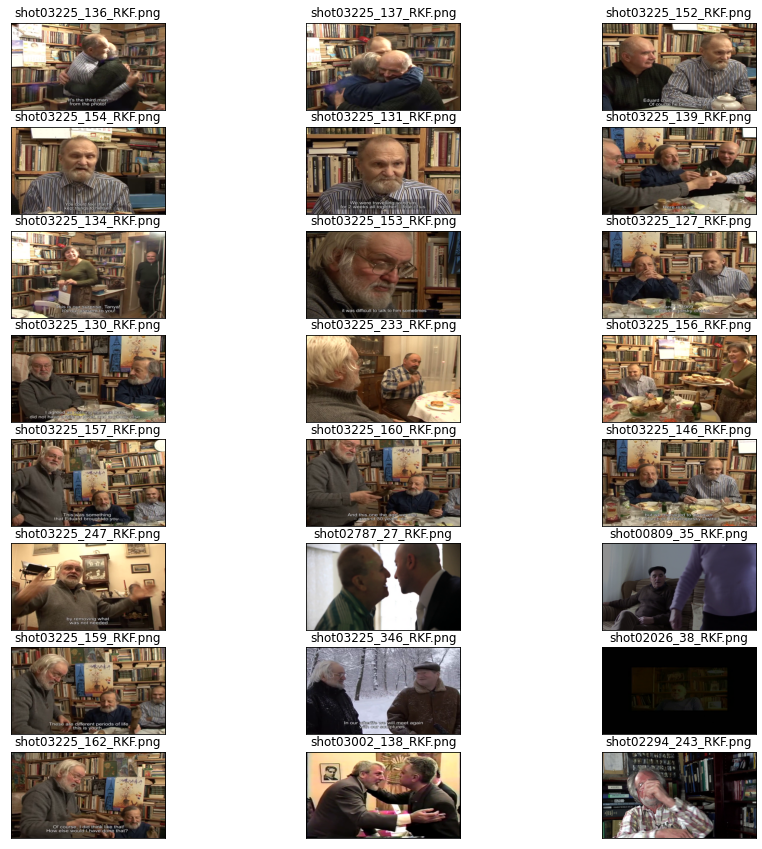

In [24]:
clip.display_results(best_images[:50], subplot_size=(8, 3))

In [19]:
clip.dataset.image_names[0]

'/mnt/SEAGATE/root/V3C1/resized_keyframes/shot00001_100_RKF.png'

In [24]:
type(clip.feature_dict)

dict

In [36]:
# clip.feature_dict['shot03225_136_RKF.png']
feature = clip.feature_dict['shot03225_136_RKF.png']
feature = np.expand_dims(feature, axis=0)
feature_vector = feature.astype('float32')
feature_vector.shape
# result = clip.search(feature_vector, num_matches=500, nlist=10, ss_type='other')

(1, 512)

In [10]:
best_images

[{'path': '/mnt/SEAGATE/root/V3C1/resized_keyframes/shot02209_26_RKF.png',
  'filename': 'shot02209_26_RKF.png',
  'dataset': None,
  'video': '02209',
  'shot': '26'}]

In [19]:
# best_images

In [9]:
with open('sample.txt', 'w') as f:
    for item in best_images:
        f.write("%s\n" % item['path'])

In [10]:
pwd

'/home/ntnhu/DCU/projects/VBS2022/CLIPsearch'

In [9]:
temp = data.image_names[0].split('/')[-1]
# x = temp.split('/')[-1]
x = temp.split('_')[-3]
x[4:]

'00001'

Length of features:  10000
Best images:  [{'filename': 'shot03956_148_RKF.png', 'dataset': None, 'video': '03956', 'shot': '148'}, {'filename': 'shot05604_75_RKF.png', 'dataset': None, 'video': '05604', 'shot': '75'}, {'filename': 'shot00126_46_RKF.png', 'dataset': None, 'video': '00126', 'shot': '46'}, {'filename': 'shot02473_57_RKF.png', 'dataset': None, 'video': '02473', 'shot': '57'}, {'filename': 'shot04771_90_RKF.png', 'dataset': None, 'video': '04771', 'shot': '90'}, {'filename': 'shot03437_132_RKF.png', 'dataset': None, 'video': '03437', 'shot': '132'}, {'filename': 'shot03247_227_RKF.png', 'dataset': None, 'video': '03247', 'shot': '227'}, {'filename': 'shot06821_414_RKF.png', 'dataset': None, 'video': '06821', 'shot': '414'}, {'filename': 'shot07466_47_RKF.png', 'dataset': None, 'video': '07466', 'shot': '47'}, {'filename': 'shot07261_83_RKF.png', 'dataset': None, 'video': '07261', 'shot': '83'}, {'filename': 'shot06825_70_RKF.png', 'dataset': None, 'video': '06825', 'shot': 

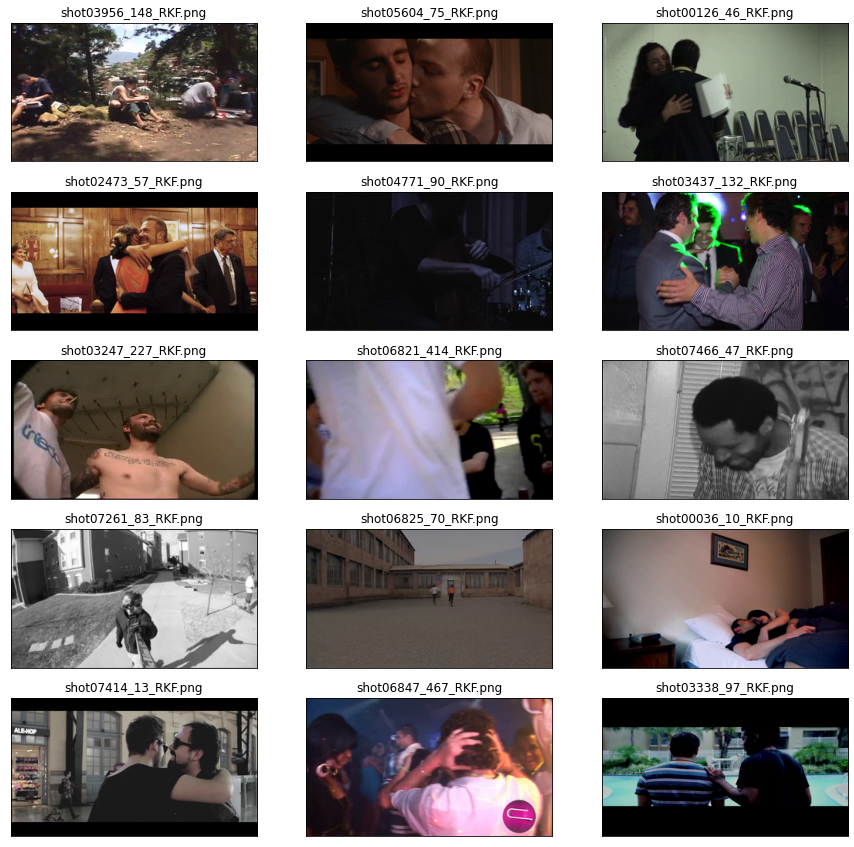

In [10]:
query = "two men hugging"
best_images = data.search_query(query, num_matches=30)
print("Length of features: ", len(data.features))
print("Best images: ", best_images)
data.display_results(best_images[:])

#### Check features of V3C dataset

In [3]:
filename = '../results/full-V3C-features/0000000000.joblib'
# image = 'shot07414_14_RKF.png'
test = joblib.load(filename)

In [4]:
len(test)

16

In [23]:
def is_image(input_string):
    extension = input_string.split('.')[-1]
    if extension == 'png' or extension == 'jpg' or extension == 'jpeg':
        return True
    return False


In [25]:
is_image(image)

True

In [26]:
is_image(filename)

False

### Resize keyframes

In [2]:
resized_path = osp.join(DATASET_MASTER_PATH, 'resized_keyframes')
original_path = osp.join(DATASET_MASTER_PATH, 'keyframes/extract/00001')

In [3]:
filename_list = os.listdir(original_path)
len(filename_list)

114

In [4]:
img_path = filename_list[0]
img_path = osp.join(original_path, img_path)

In [6]:
img_path.split('/')

['',
 'mnt',
 'SEAGATE',
 'root',
 'V3C1',
 'keyframes',
 'extract',
 '00001',
 'shot00001_44_RKF.png']

In [32]:
import cv2
def resize_image(img_path, scale_percent=50, rename=False, filename=None):
    src_img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    scale_percent = scale_percent

    #calculate the 50 percent of original dimensions
    width = int(src_img.shape[1] * scale_percent / 100)
    height = int(src_img.shape[0] * scale_percent / 100)
    dsize = (width, height)

    # resize image
    output = cv2.resize(src_img, dsize)
    
    if rename:
        cv2.imwrite(filename, output)
        return
        
    return output



In [33]:
resize_image(img_path, 25, rename=True, filename='abc.png')

In [28]:
output = resize_image(filename, 25)

In [29]:
output.shape

(180, 320, 3)

#### Checking with results

In [55]:
results = ['b00002410_21i6bq_20150319_162318e',
        'b00002411_21i6bq_20150319_162318e',
        'b00002412_21i6bq_20150319_162319e',
        'b00002413_21i6bq_20150319_162320e',
        'b00002414_21i6bq_20150319_162320e']

In [56]:
# result = results[0]
result = 'B00012817_21I6X0_20180524_041616E.JPG'
best_image = best_images[0]['filename']

In [57]:
len(best_images)

200

In [58]:
for result in results:
    for image in best_images:
        image_name = image['filename'].split('/')[-1].split('.')[0]
#         print(image_name)
        if image_name in result:
            print(image)

### Split keyframes to subfolders

In [2]:
import subprocess

In [3]:
# folder_name = 'test_folder'
# path = osp.join('/home/ntnhu/projects/VideoFall-VBS2022/results/', folder_name)
# if not osp.isdir(path):
#     os.mkdir(path)
# subprocess.call(f"mv /home/ntnhu/projects/VideoFall-VBS2022/results/xxx/* {path}", shell=True)


1

In [7]:
V3C2_path = '/mnt/SEAGATE/root/V3C2/keyframes/'
V3C2_videos = sort_list(os.listdir(V3C2_path))
V3C2_keyframes = sort_list(glob(osp.join(V3C2_path, '*/*.png')))

In [9]:
V3C2_videos[-2]

'17235'

In [4]:
keyframe_path = '/mnt/DEAKIN/VBS2022/resized_keyframes/*.png'
keyframes = sort_list(glob(keyframe_path))

In [21]:
keyframes[0].split('/')[-1][4:9]

'00001'

In [26]:
for kf in tqdm(keyframes[10000:100000]):
    video_name = kf.split('/')[-1][4:9]
    video_path = osp.join('/mnt/DEAKIN/VBS2022/keyframes/', video_name)
    if not osp.isdir(video_path):
        os.mkdir(video_path)
#     print(kf)
    subprocess.call(f"mv {kf} {video_path}", shell=True)

100%|██████████| 90000/90000 [40:34<00:00, 36.97it/s]  


In [24]:
# max_len = 17235
# for idx in range(1, 5):
#     video_name = f'{idx:05d}'
#     video_path = osp.join('/mnt/DEAKIN/VBS2022/keyframes/', video_name)
#     if not osp.isdir(video_path):
#         os.mkdir(video_path)
#     for kf in tqdm(keyframes[:1000]):
#         if f'shot{video_name}' in kf:
# #             print(kf)
#             subprocess.call(f"cp {kf} {video_path}", shell=True)
    

In [27]:
temp_path = '/mnt/DEAKIN/VBS2022/resized_keyframes/*.png'
temp = sort_list(glob(temp_path))

In [28]:
len(temp)

1997152

### Yolov5

In [42]:
def save_df_to_json(data_df, filename, orient='records', indent=4):
    data = data_df.to_json(orient=orient) 
    parsed_data = json.loads(data)    
    with open(filename, 'w') as f:
        json.dump(parsed_data, f, indent=indent)

In [44]:
import json
temp = results.pandas().xyxy[0]
save_df_to_json(temp, 'temp_2.json')

In [39]:
with open('temp.json', 'r') as outfile:
    data = json.load(outfile)

JSONDecodeError: Expecting value: line 1 column 1 (char 0)